In [1117]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import copy

In [1118]:
"""
By Lauren Schmutz (contact: lschmutz@andrew.cmu.edu). Pushed to github __
Notes:
1. 
"""

"""
Changes made by Luna (contact: lanyuntw@andrew.cmu.edu). Pushed to github __
Notes:
1. distribution list 
"""

'\nBy Lauren Schmutz (contact: lschmutz@andrew.cmu.edu). Pushed to github __\nNotes:\n1. \n'

In [1119]:
#helper: display combining trees
def displayChart(tab):
    Chart=[]
    columns = []
    N = len(tab)-1
    for i in range(N, -1, -1):
        chart = []
        columns.append(N-i)
        for j in range(0,i):
            chart.append("")
        for j in range(i, N+1):
            entry = tab[j][i]
            chart.append(entry)
        Chart.append(chart)
    df = pd.DataFrame(Chart, columns = columns)
    return df.style.hide_index()

In [1120]:
#helper: convert list to dict
def list_to_dict(L):
    res = {}
    for i in range(len(L)):
        res[i] = L[i]
    return res

In [1121]:
#helper: creaet recombining
def tree(t, init, up, down, negative_allowed):
    """t=num of time periods. init=initial value. up, down factors : num, negative values allowed : bool."""
    res = {}
    gap = up+down
    if negative_allowed:
        for i in range(t+1):
            res[i] = np.arange(init-i*down, init+(i+1)*up, gap)
    else:
        for i in range(t+1):
            res[i] = np.maximum(np.zeros(i+1), np.arange(init-i*down, init+(i+1)*up, gap))
    return res

def flip_tree(tree, t):
    res = {}
    for i in range(t+1):
        a = np.ndarray.copy(tree[i])
        res[i] = np.flip(a)
    return res

In [1122]:
#initialize a holee interest rate. create_tree method creates the tree.
#note that you are permitted to put "negative volatilities" even if that might not make sense
class HoLee:
    def __init__(self, periods, R0, lam, sig):
        self.periods = periods
        self.R0 = R0
        self.lam = lam # drift
        self.sig = sig # volatility
        self.tree_exists = False

    def create_tree(self):
        self.up = self.lam+self.sig
        self.down = self.sig-self.lam
        self.tree = tree(self.periods, self.R0, self.up, self.down, True)
        self.tree_exists = True
        return self.tree

In [1123]:
class Stocks:
    def __init__(self, periods, S0, alpha, beta):
        self.periods = periods
        self.S0 = S0
        self.alpha = alpha
        self.up = self.alpha
        self.beta = beta
        self.down = self.beta
        self.tree_exists = False

    def create_tree(self):
        self.tree = tree(self.periods, self.S0, self.alpha, self.beta, False)
        self.tree_exists = True
        return self.tree

In [1124]:
class Model:
    """Model contains objects from HoLee, Stocks. Creation of trees are delayed via methods to address potential efficiency concerns."""
    def __init__(self, periods):
        self.periods = periods
        self.stocks_exist = False
        self.rates_exist = False
        self.arbitrage = False
    
    def init_stocks(self, S0, alpha, beta):
        self.stocks_obj = Stocks(self.periods, S0, alpha, beta)
        self.stock_up = alpha
        self.stock_down = beta
        self.stocks_tree = self.stocks_obj.create_tree()
        self.stocks_exist = True

    def init_HoLee(self, R0, lam, sig):
        self.rates_obj = HoLee(self.periods, R0, lam, sig)
        self.rate_up = lam+sig
        self.rate_down = sig-lam
        self.rates_tree = self.rates_obj.create_tree()
        # self.neg_rates_obj = HoLee(self.periods, R0, lam, -1*sig)
        self.neg_rates_tree = flip_tree(self.rates_tree, self.periods)
        self.rates_exist = True

In [1125]:
def rate_p_values(model):
    t = model.periods
    res = {}
    for i in range(t):
        res[i] = np.full(i+1, 0.5)
    res[t] = np.ones(t+1)
    # model.rate_p_vals = res
    return res

In [1126]:
def p_values(model):
    t = model.periods
    if not (model.stocks_exist and model.rates_exist):
            print("need to initialize stocks and/or rates")
            return None
    stock_price_chart = model.stocks_tree
    rates = model.rates_tree
    P = {i: np.ones(i+1) for i in range (t+1)}
    # P = {i: [1]*(i+1) for i in range(t+1)}
    for i in range(0, t):
        for j in range(i+1):
            if stock_price_chart[i][j] == 0:
                P[i][j] = -1
            else:
                d = stock_price_chart[i+1][j] / stock_price_chart[i][j]
                u = stock_price_chart[i+1][j+1] / stock_price_chart[i][j]
                p_soon = (1 + rates[i][j] - d) / (u-d)
                if (p_soon<0) or (p_soon>1):
                    model.arbitrage = True
                P[i][j] = p_soon
    return P

In [1127]:
# Idea: one dictionary. Key: integer tuple (time period, # stock heads, # tails), Value: bond price before coupon.
#                                                                             or: value: [bond price b4 coup, coup at time]

def call_helper(cur_exp, cur_stock, cur_conv, cur_call, bh_prio):
    if cur_call != None:
        m1 = cur_stock * cur_conv
        if bh_prio:
            m2 = min(cur_exp, cur_call)
            cur_exp = max(m1, m2)
        else:
            m2 = max(m1, cur_exp)
            cur_exp = min(m2, cur_call)
    else:
        cur_exp = max(cur_conv*cur_stock, cur_exp)
    return cur_exp

def two_coin_helper(self):
    if not self.init_p_vals:
        return False
    # self.p_vals = p_values(self.model)
    # self.rate_p_vals = rate_p_values(self.model)
    face = self.face
    t = self.model.periods
    S = self.model.stocks_tree
    R = self.model.rates_tree
    S_p = self.p_vals
    R_p = self.rate_p_vals
    coup = self.coup
    res = {}
    bh_prio = self.bh_prio
    #fill in the last period 
    cur_call = self.call_dict[t]
    cur_conv = self.conv_dict[t]
    for i in range(t+1):            #i: number of stock heads
        for j in range(t+1):        #j: number of rate heads
            cur_stock = S[t][i]
            res[(t, i, j)] = [0,0]
            if cur_stock > 0:
                cur_exp = face * (self.distr_dict[t][2] if cur_stock <= self.distr_dict[t][0] else 1)
                cur_exp = call_helper(cur_exp, cur_stock, cur_conv, cur_call, bh_prio)
                res[(t, i, j)][0] = cur_exp
            res[(t, i, j)][1] = coup if cur_stock > self.distr_dict[t][0] else (self.distr_dict[t][1] * coup if cur_stock > 0 else 0)
    #Backwards Induction:
    for n in range(t-1, -1, -1):
        cur_call = self.call_dict[n]
        cur_conv = self.conv_dict[n]
        for i in range(n+1):        #i: number of stock heads
            for j in range(n+1):    #j: number of rate heads
                cur_stock = S[n][i]
                cur_rate = R[n][j]
                cur_disc = 1/(1+cur_rate)
                #p values
                s_h_p = S_p[n][i]
                s_t_p = 1 - s_h_p
                r_h_p = R_p[n][j]
                r_t_p = 1 - r_h_p
                #stock head rate head
                hh = res[(n+1, i+1, j+1)][0]
                hh_c = res[(n+1, i+1, j+1)][1]
                #stock head rate tail
                ht = res[(n+1, i+1, j)][0]
                ht_c = res[(n+1, i+1, j)][1]
                #stock tail rate head
                th = res[(n+1, i, j+1)][0]
                th_c = res[(n+1, i, j+1)][1]
                #stock tail rate tail
                tt = res[(n+1, i, j)][0]
                tt_c = res[(n+1, i, j)][1]
                #fill formula
                cur_exp = 0 if cur_stock == 0 else cur_disc * (s_h_p*r_h_p*(hh+hh_c) + s_h_p*r_t_p*(ht+ht_c) + s_t_p*r_h_p*(th+th_c) + s_t_p*r_t_p*(tt+tt_c))
                #call
                cur_exp = call_helper(cur_exp, cur_stock, cur_conv, cur_call, bh_prio)
                res[(n, i, j)] = [0,0]
                res[(n, i, j)][0] = cur_exp
                res[(n, i, j)][1] = coup if cur_stock > self.distr_dict[n][0] else (self.distr_dict[n][1] * coup if cur_stock > 0 else 0)
                if n == 0: res[(n, i, j)][1] = 0
    if self.model.arbitrage: print("WARNING: Arbitrage exists in model.")
    return res

In [1128]:
def one_coin_helper(self, rates_tree):
        if not self.init_p_vals():
            return False
        face = self.face
        t = self.model.periods
        S = self.model.stocks_tree
        R = rates_tree
        S_p = self.p_vals
        coup = self.coup
        res = {}
        bh_prio = self.bh_prio
        #fill in the last period 
        cur_call = self.call_dict[t]
        cur_conv = self.conv_dict[t]
        for i in range(t+1):
            cur_stock = S[t][i]
            res[(t, i)] = [0,0]
            if cur_stock > 0:
                cur_exp = face * (self.distr_dict[t][2] if cur_stock <= self.distr_dict[t][0] else 1)
                cur_exp = call_helper(cur_exp, cur_stock, cur_conv, cur_call, bh_prio)
                res[(t, i)][0] = cur_exp
            res[(t, i)][1] = coup if cur_stock > self.distr_dict[t][0] else (self.distr_dict[t][1] * coup if cur_stock > 0 else 0)
        for n in range(t-1, -1, -1):
            cur_call = self.call_dict[n]
            cur_conv = self.conv_dict[n]
            for i in range(n+1):        #i: number of stock heads
                cur_stock = S[n][i]
                cur_rate = R[n][i]
                cur_disc = 1/(1+cur_rate)
                #p values
                h_p = S_p[n][i]
                t_p = 1 - h_p
                #stock head rate head
                h = res[(n+1, i+1)][0]
                h_c = res[(n+1, i+1)][1]
                #stock tail rate head
                t = res[(n+1, i)][0]
                t_c = res[(n+1, i)][1]
                #fill formula
                cur_exp = 0 if cur_stock == 0 else cur_disc * (h_p*(h+h_c) + t_p*(t+t_c))
                #call
                cur_exp = call_helper(cur_exp, cur_stock, cur_conv, cur_call, bh_prio)
                res[(n, i)] = [0,0]
                res[(n, i)][0] = cur_exp
                res[(n, i)][1] = coup if cur_stock > self.distr_dict[n][0] else (self.distr_dict[n][1] * coup if cur_stock > 0 else 0)
                if n == 0: res[(n, i)][1] = 0
        if self.model.arbitrage: print("WARNING: Arbitrage exists in model.")
        return res

In [1129]:
class Bond:
    def __init__(self, model, face, q, distr_list, conv_list, call_list, bh_prio):
        self.model = model
        self.periods = self.model.periods
        self.face = face
        self.q = q
        self.coup = self.face * self.q
        self.distr_dict = list_to_dict(distr_list)
        self.conv_dict = list_to_dict(conv_list)
        self.call_dict = list_to_dict(call_list)
        self.p_vals_exist = False
        self.bh_prio = bh_prio

    def init_p_vals(self):
        if not (self.model.stocks_exist or self.model.rates_exist):
            print("need to initialize stocks and rates in outer model. do so and try again")
            return False
        elif not self.model.stocks_exist:
            print("need to initialize stocks in outer model. do so and try again")
            return False
        elif not self.model.rates_exist:
            print("need to initialize rates in outer model. do so and try again")
            return False
        else:
            self.p_vals = p_values(self.model)
            self.rate_p_vals = rate_p_values(self.model)
            if self.model.arbitrage: print("WARNING: Arbitrage exists in model.")
            return True
    
    def one_coin_pos(self):
        return (one_coin_helper(self, self.model.rates_tree))[(0,0)][0]
    
    def one_coin_neg(self):
        return (one_coin_helper(self, self.model.neg_rates_tree))[(0,0)][0]
    
    def two_coin(self):
        return (two_coin_helper(self))[(0,0,0)][0]



In [1130]:
############################
# INITIALIZING STOCKS
############################
t_global = 10
model = Model(t_global)
model.init_stocks(30,13,13)
print("stocks")
displayChart(model.stocks_tree)

stocks


/var/folders/bw/yjjm_7gs7vv11d3rbv60z3p00000gn/T/ipykernel_53763/1107203987.py:16: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.style.hide_index()


0,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,160.000000
,,,,,,,,,147.000000,134.000000
,,,,,,,,134.000000,121.000000,108.000000
,,,,,,,121.000000,108.000000,95.000000,82.000000
,,,,,,108.000000,95.000000,82.000000,69.000000,56.000000
,,,,,95.000000,82.000000,69.000000,56.000000,43.000000,30.000000
,,,,82.000000,69.000000,56.000000,43.000000,30.000000,17.000000,4.000000
,,,69.000000,56.000000,43.000000,30.000000,17.000000,4.000000,0.000000,0.000000
,,56.000000,43.000000,30.000000,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000
,43.000000,30.000000,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [1131]:
############################
# INITIALIZING RATES
############################
model.init_HoLee(0.04, 0.001, 0.001)
print("interest rates")
displayChart(model.rates_tree)

interest rates


/var/folders/bw/yjjm_7gs7vv11d3rbv60z3p00000gn/T/ipykernel_53763/1107203987.py:16: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.style.hide_index()


0,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,0.060000
,,,,,,,,,0.058000,0.058000
,,,,,,,,0.056000,0.056000,0.056000
,,,,,,,0.054000,0.054000,0.054000,0.054000
,,,,,,0.052000,0.052000,0.052000,0.052000,0.052000
,,,,,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
,,,,0.048000,0.048000,0.048000,0.048000,0.048000,0.048000,0.048000
,,,0.046000,0.046000,0.046000,0.046000,0.046000,0.046000,0.046000,0.046000
,,0.044000,0.044000,0.044000,0.044000,0.044000,0.044000,0.044000,0.044000,0.044000
,0.042000,0.042000,0.042000,0.042000,0.042000,0.042000,0.042000,0.042000,0.042000,0.042000


In [1132]:
distr_list = [(10, 0.1) for i in range(t_global + 1)]
distr_list[t_global] = (10, 0.1, 0.33)
conv_list = np.ones(t_global+1)
call_list = np.full(t_global+1, None)
call_list[5] = 55
call_list[10] = 55
cbond1 = Bond(model, 50, 0.04, distr_list, conv_list, call_list, True)
cbond1.init_p_vals()
print("p tilde")
displayChart(cbond1.p_vals)

p tilde


/var/folders/bw/yjjm_7gs7vv11d3rbv60z3p00000gn/T/ipykernel_53763/1107203987.py:16: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.style.hide_index()


0,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,1.000000
,,,,,,,,,0.827923,1.000000
,,,,,,,,0.788615,0.760615,1.000000
,,,,,,,0.751308,0.724308,0.697308,1.000000
,,,,,,0.716000,0.690000,0.664000,0.638000,1.000000
,,,,,0.682692,0.657692,0.632692,0.607692,0.582692,1.000000
,,,,0.651385,0.627385,0.603385,0.579385,0.555385,0.531385,1.000000
,,,0.622077,0.599077,0.576077,0.553077,0.530077,0.246118,-1.000000,1.000000
,,0.594769,0.572769,0.550769,0.528769,0.245647,-1.000000,-1.000000,-1.000000,1.000000
,0.569462,0.548462,0.527462,0.245176,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000


In [ ]:
displayChart()

In [1133]:
print("rate p tilde")
displayChart(cbond1.rate_p_vals)

rate p tilde


/var/folders/bw/yjjm_7gs7vv11d3rbv60z3p00000gn/T/ipykernel_53763/1107203987.py:16: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.style.hide_index()


0,1,2,3,4,5,6,7,8,9,10
,,,,,,,,,,1.000000
,,,,,,,,,0.500000,1.000000
,,,,,,,,0.500000,0.500000,1.000000
,,,,,,,0.500000,0.500000,0.500000,1.000000
,,,,,,0.500000,0.500000,0.500000,0.500000,1.000000
,,,,,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000
,,,,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000
,,,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000
,,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000
,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000


In [1134]:
print(cbond1.one_coin_pos())
print(cbond1.two_coin())
print(cbond1.one_coin_neg())
#D[(n, i, j)] = [bond_value_before_coupon, coupon] where n is time period, i number of stock heads, j number of rate heads

41.291303315463146
41.448149329854324
41.45633544732222


In [1135]:
def sim_two_coin(t, x, r, rate_vol):
    model = Model(t)
    model.init_stocks(30,x,x)
    model.init_HoLee(r, rate_vol, rate_vol)
    distr_list = [(t, 0) for i in range(t + 1)]
    distr_list[t_global] = (t, 0, 0.5)
    conv_list = np.ones(t+1)
    call_list = np.full(t+1, None)
    cbond1 = Bond(model, 50, r, distr_list, conv_list, call_list)
    cbond1.init_p_vals()
    D = cbond1.two_coin()
    return D[(0,0,0)][0]

In [1136]:
############################
# INVESTIGATE: BOND PRICE VS STOCK VOLATILITY
# HOLEE 0.001 DRIFT 0.001 VOLATILITY
# CALLABLE WITH BH OR ISS PRIO AT T=5, T=10
# CONVERTIBLE TO ONE SHARE AT ALL PERIODS
############################

distr_list = [(10, 0.1) for i in range(t_global + 1)]
distr_list[t_global] = (10, 0.1, 0.33)
conv_list = np.ones(t_global+1)
call_list = np.full(t_global+1, None)
call_list[5] = 55
call_list[10] = 55
face = 50
coup = 0.04
b_prio = True

pos_cor = []
ind = []
neg_cor = []

pos_cor1 = []
ind1 = []
neg_cor1 = []

lower = 4
upper = 50

model1 = Model(t_global)
model1.init_HoLee(0.04, 0.001, 0.001)

# model1.init_stocks(30,4,4)
xvals = np.arange(lower, upper)
xvals = xvals / 30

for v in range(lower, upper):
    model1.init_stocks(30, v, v)
    test = Bond(model1, face, coup, distr_list, conv_list, call_list, b_prio)
    test1 = Bond(model1, face, coup, distr_list, conv_list, call_list, (not b_prio))
    pos_cor.append(test.one_coin_pos())
    ind.append(test.two_coin())
    neg_cor.append(test.one_coin_neg())
    pos_cor1.append(test1.one_coin_pos())
    ind1.append(test1.two_coin())
    neg_cor1.append(test1.one_coin_neg())

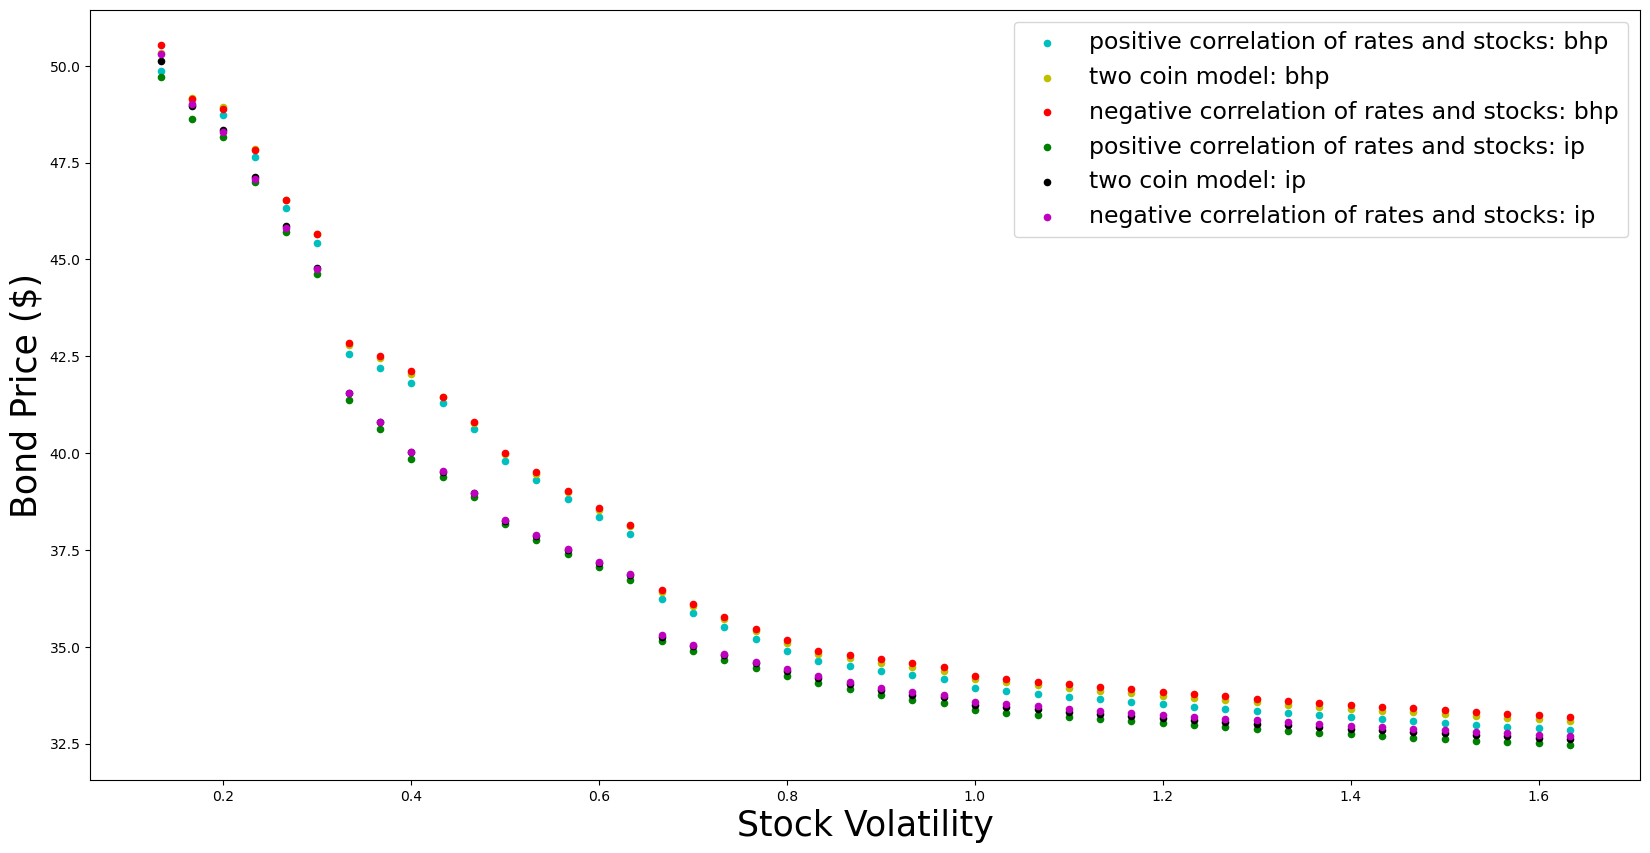

In [1137]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot()
plt.xlabel('Stock Volatility', fontsize = 25) 
plt.ylabel('Bond Price ($)', fontsize = 25)

ax1.scatter(xvals, pos_cor, s=20, c='c', label="positive correlation of rates and stocks: bhp")
ax1.scatter(xvals, ind, s=20, c='y', label="two coin model: bhp")
ax1.scatter(xvals, neg_cor, s=20, c='r', label="negative correlation of rates and stocks: bhp")

ax1.scatter(xvals, pos_cor1, s=20, c='g', label="positive correlation of rates and stocks: ip")
ax1.scatter(xvals, ind1, s=20, c='k', label="two coin model: ip")
ax1.scatter(xvals, neg_cor1, s=20, c='m', label="negative correlation of rates and stocks: ip")

plt.legend(loc='upper right', fontsize = 17)
plt.show() 

In [1138]:
############################
# INVESTIGATE: BOND PRICE VS CALL DATES
# HOLEE 0.001 DRIFT 0.001 VOLATILITY
# ADDITIVE STOCK ALPHA=BETA=10
# CALLABLE WITH BH OR ISS PRIO AT T=5, T=10
# CONVERTIBLE TO ONE SHARE AT ALL PERIODS
# CALL AT TIME "11" INDICATES NO CALL OPTION
# CALL AT TIME n<=10 INDICATES CALLABLE AT ALL TIMES t>=n
############################

distr_list2 = [(10, 0.1) for i in range(t_global + 1)]
distr_list2[t_global] = (10, 0.1, 0.33)
conv_list2 = np.ones(t_global+1)
call_list2 = np.full(t_global+1, None)
face2 = 50
coup2 = 0.04
b_prio2 = True

vol2 = 10

model2 = Model(t_global)
model2.init_stocks(30, vol2, vol2)
model2.init_HoLee(0.04, 0.001, 0.001)

xvals2 = np.arange(11, 0, -1) #11 to 1

pc2a = []
ind2a= []
nc2a = []

pc2b = []
ind2b= []
nc2b = []


for n in range(10, -1, -1):
    test2a = Bond(model2, face2, coup2, distr_list2, conv_list2, call_list2, b_prio2)
    test2b = Bond(model2, face2, coup2, distr_list2, conv_list2, call_list2, not b_prio2)

    pc2a.append(test2a.one_coin_pos())
    ind2a.append(test2a.two_coin())
    nc2a.append(test2a.one_coin_neg())

    pc2b.append(test2b.one_coin_pos())
    ind2b.append(test2b.two_coin())
    nc2b.append(test2b.one_coin_neg())

    call_list2[n] = 55

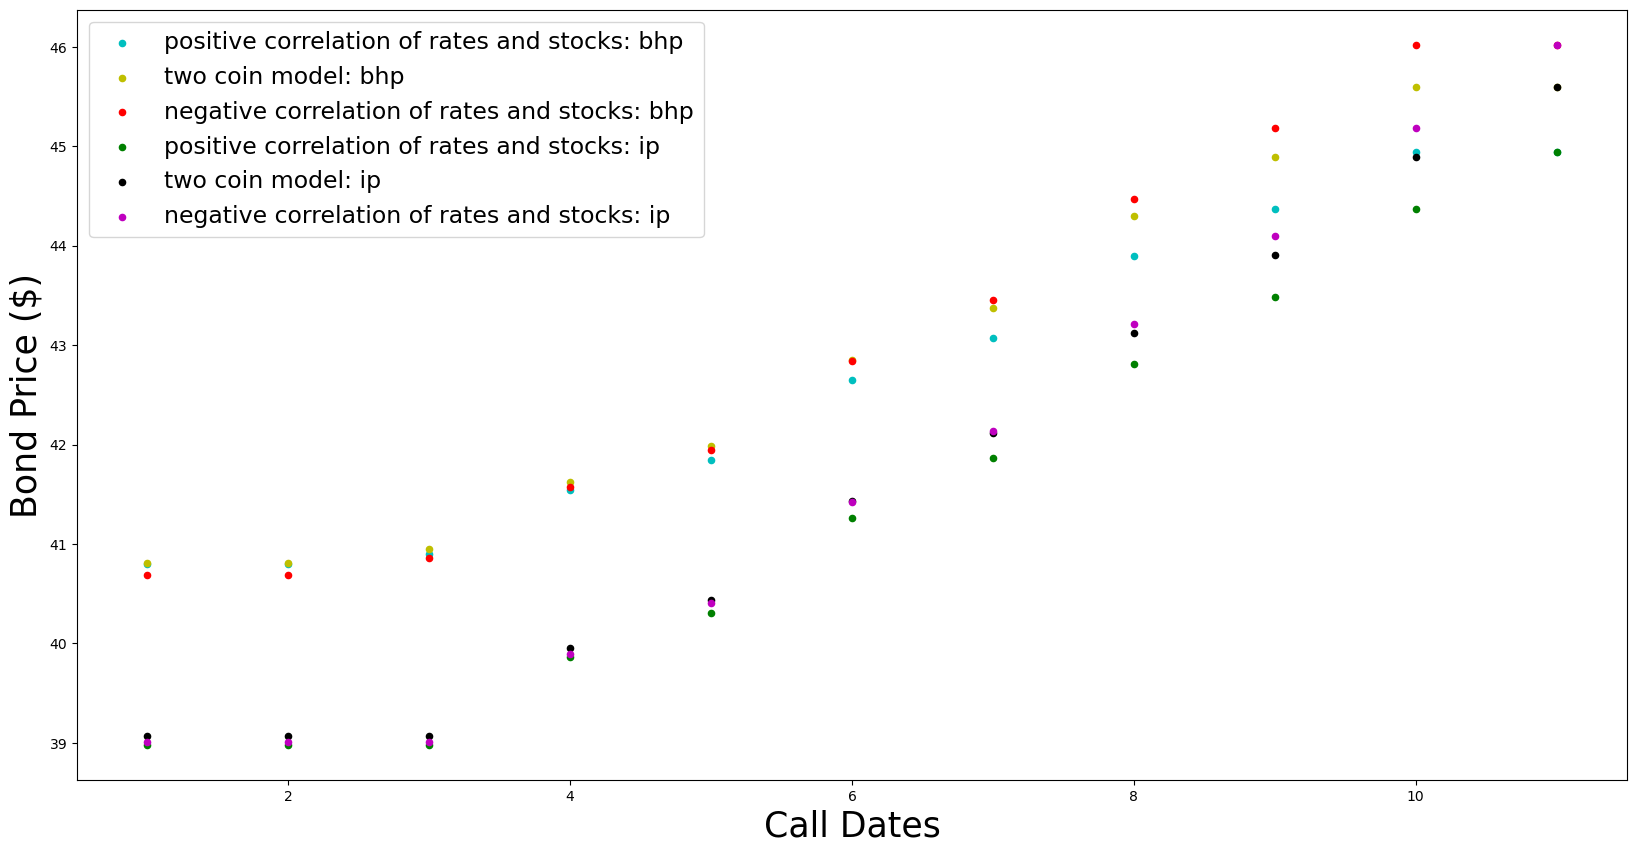

In [1139]:
fig2 = plt.figure(figsize=(20,10))
ax2 = fig2.add_subplot()
plt.xlabel('Call Dates', fontsize = 25) 
plt.ylabel('Bond Price ($)', fontsize = 25)

ax2.scatter(xvals2, pc2a, s=20, c='c', label="positive correlation of rates and stocks: bhp")
ax2.scatter(xvals2, ind2a, s=20, c='y', label="two coin model: bhp")
ax2.scatter(xvals2, nc2a, s=20, c='r', label="negative correlation of rates and stocks: bhp")

ax2.scatter(xvals2, pc2b, s=20, c='g', label="positive correlation of rates and stocks: ip")
ax2.scatter(xvals2, ind2b, s=20, c='k', label="two coin model: ip")
ax2.scatter(xvals2, nc2b, s=20, c='m', label="negative correlation of rates and stocks: ip")

plt.legend(loc='upper left', fontsize = 17)
plt.show() 

In [1140]:
############################
# INVESTIGATE: BOND PRICE VS CONVERSION AMOUNTS
# HOLEE 0.001 DRIFT 0.001 VOLATILITY
# CALLABLE WITH BH OR ISS PRIO AT T=5, T=10
# CONVERTIBLE TO 1-2 SHARES AT ALL PERIODS (SAME VALUE)
# ALPHA = BETA = 10
# THIS PRESERVES LAST PERIOD CONVERSION, HENCE LINEAR RELATIONSHIP
############################

distr_list3 = [(10, 0.1) for i in range(t_global + 1)]
distr_list3[t_global] = (10, 0.1, 0.33)
# conv_list3 = np.ones(t_global+1)
call_list3 = np.full(t_global+1, None)
call_list3[5] = 55
call_list3[10] = 55
face3 = 50
coup3 = 0.04
b_prio3 = True

pc3a = []
ind3a = []
nc3a = []

pc3b = []
ind3b = []
nc3b = []

lower = 0
upper = 50

model3 = Model(t_global)
model3.init_HoLee(0.04, 0.001, 0.001)

model3.init_stocks(30,10,10)
xvals3 = np.arange(lower, upper)

xvals3 = (xvals3 / 50) + 1

for s in range(lower, upper):

    v = (s/50)+1
    conv_list3 = np.full(t_global+1, v)

    test3a = Bond(model3, face3, coup3, distr_list3, conv_list3, call_list3, b_prio3)
    test3b = Bond(model3, face3, coup3, distr_list3, conv_list3, call_list3, not(b_prio3))

    pc3a.append(test3a.one_coin_pos())
    ind3a.append(test3a.two_coin())
    nc3a.append(test3a.one_coin_neg())
    pc3b.append(test3b.one_coin_pos())
    ind3b.append(test3b.two_coin())
    nc3b.append(test3b.one_coin_neg())

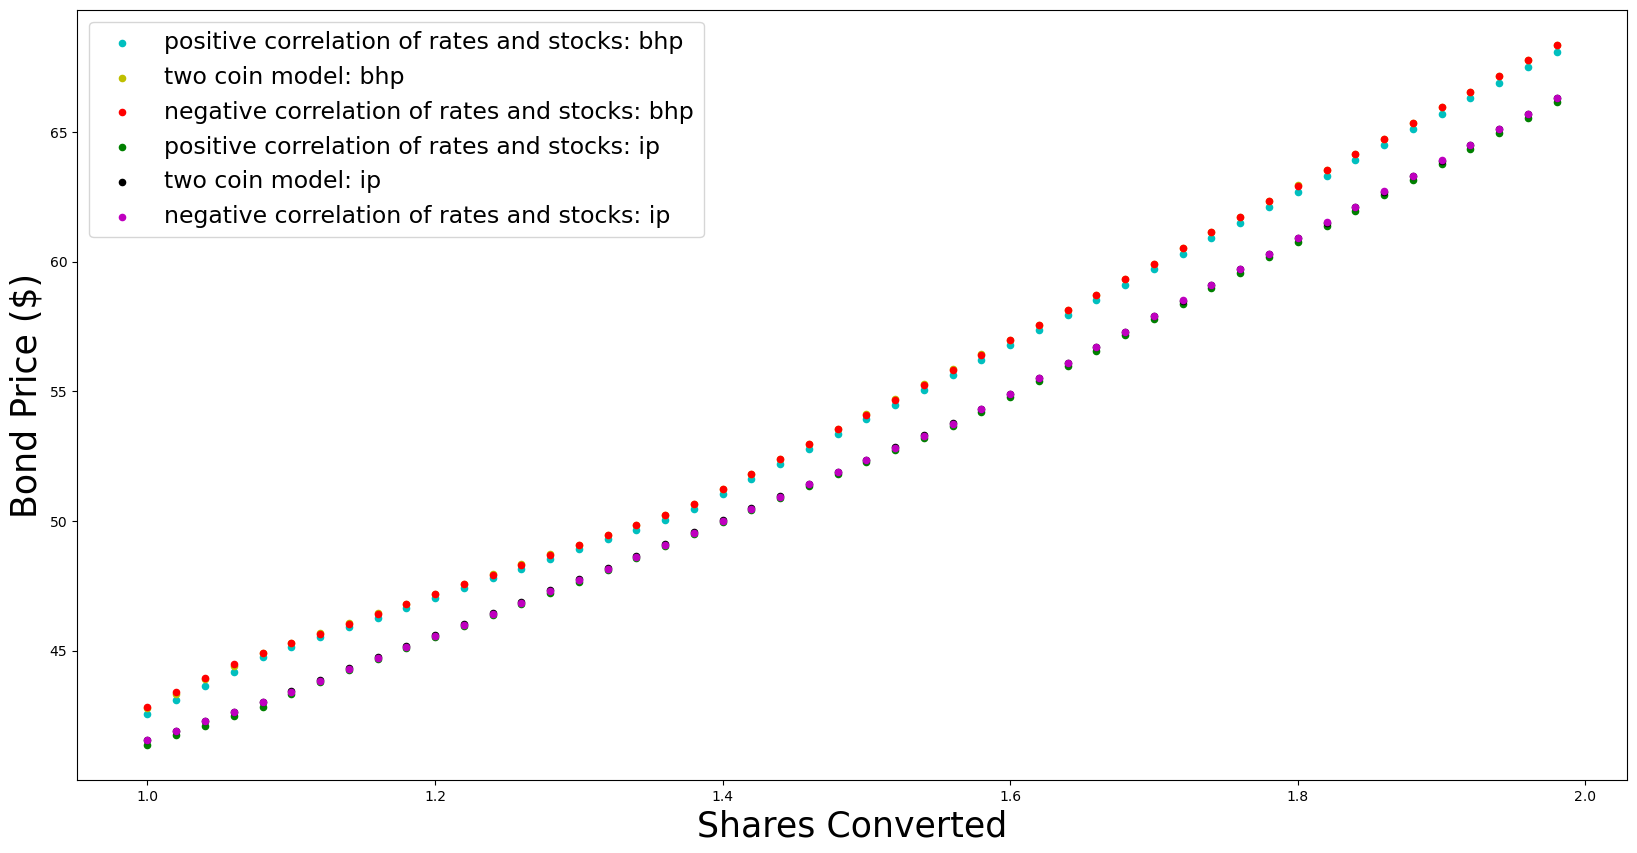

In [1141]:
fig3 = plt.figure(figsize=(20,10))
ax3 = fig3.add_subplot()
plt.xlabel('Shares Converted', fontsize = 25) 
plt.ylabel('Bond Price ($)', fontsize = 25)

ax3.scatter(xvals3, pc3a, s=20, c='c', label="positive correlation of rates and stocks: bhp")
ax3.scatter(xvals3, ind3a, s=20, c='y', label="two coin model: bhp")
ax3.scatter(xvals3, nc3a, s=20, c='r', label="negative correlation of rates and stocks: bhp")

ax3.scatter(xvals3, pc3b, s=20, c='g', label="positive correlation of rates and stocks: ip")
ax3.scatter(xvals3, ind3b, s=20, c='k', label="two coin model: ip")
ax3.scatter(xvals3, nc3b, s=20, c='m', label="negative correlation of rates and stocks: ip")

plt.legend(loc='upper left', fontsize = 17)
plt.show() 

In [1142]:
############################
# INVESTIGATE: BOND PRICE VS TIME 5 CONVERSION AMOUNT
# HOLEE 0.001 DRIFT 0.001 VOLATILITY
# CALLABLE WITH BH OR ISS PRIO AT T=10
# CONVERTIBLE TO 1-2 SHARES AT ALL PERIODS (SAME VALUE)
# ALPHA = BETA = 10
# THIS PRESERVES LAST PERIOD CONVERSION, HENCE LINEAR RELATIONSHIP
############################

distr_list4 = [(10, 0.1) for i in range(t_global + 1)]
distr_list4[t_global] = (10, 0.1, 0.33)
conv_list4 = np.ones(t_global+1)
call_list4 = np.full(t_global+1, None)
call_list4[5] = 55
call_list4[10] = 55
face4 = 50
coup4 = 0.04
b_prio4 = True

pc4a = []
ind4a = []
nc4a = []

pc4b = []
ind4b = []
nc4b = []

lower = 0
upper = 50

model4 = Model(t_global)
model4.init_HoLee(0.04, 0.001, 0.001)

model4.init_stocks(30,10,10)
xvals4 = np.arange(lower, upper)

xvals4 = (xvals4 / 50) + 1

for s in range(lower, upper):

    v = (s/50)+1
    conv_list4[5] = v

    test4a = Bond(model4, face4, coup4, distr_list4, conv_list4, call_list4, b_prio4)
    test4b = Bond(model4, face4, coup4, distr_list4, conv_list4, call_list4, not (b_prio4))

    pc4a.append(test4a.one_coin_pos())
    ind4a.append(test4a.two_coin())
    nc4a.append(test4a.one_coin_neg())
    pc4b.append(test4b.one_coin_pos())
    ind4b.append(test4b.two_coin())
    nc4b.append(test4b.one_coin_neg())

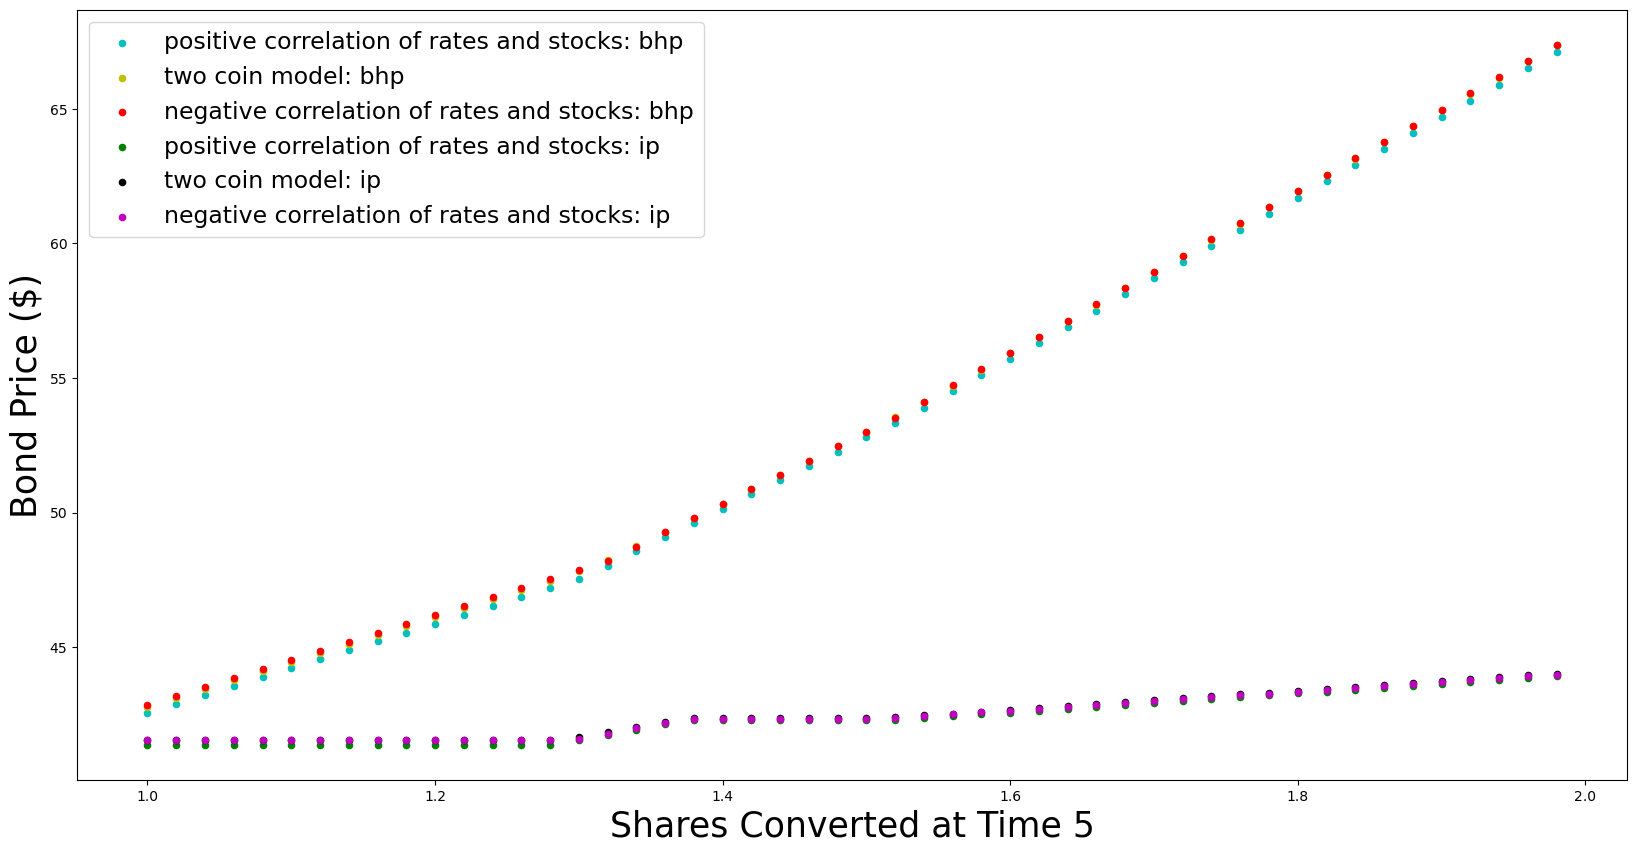

In [1143]:
fig4 = plt.figure(figsize=(20,10))
ax4 = fig4.add_subplot()
plt.xlabel('Shares Converted at Time 5', fontsize = 25) 
plt.ylabel('Bond Price ($)', fontsize = 25)

ax4.scatter(xvals4, pc4a, s=20, c='c', label="positive correlation of rates and stocks: bhp")
ax4.scatter(xvals4, ind4a, s=20, c='y', label="two coin model: bhp")
ax4.scatter(xvals4, nc4a, s=20, c='r', label="negative correlation of rates and stocks: bhp")

ax4.scatter(xvals4, pc4b, s=20, c='g', label="positive correlation of rates and stocks: ip")
ax4.scatter(xvals4, ind4b, s=20, c='k', label="two coin model: ip")
ax4.scatter(xvals4, nc4b, s=20, c='m', label="negative correlation of rates and stocks: ip")

plt.legend(loc='upper left', fontsize = 17)
plt.show() 